### Time to get your hands dirty. Black-hole binary formation channels with gaussian mixtures.
Some events form in different astrophysical environments than others. **You want to figure out how many of formation channels are at play.**


The strategy here is to fit a Gaussian Mixture model: that is, my model is a sum of $N$ gaussians each with mean $\mu_j$ and standard deviation $\sigma_j$ and weight $\alpha_j$:

$p(x_i|\theta) = \sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j) $

This depends on $3N-1$ parameters (not $3N$ because the sum of the $\alpha_j$ must be unity to ensure that this is a probability.

#### Tasks

1) Load this file (`np.load`) and complete a quick exploration of the data. How many modes do you think you see?

2) Take some time to explore `sklearn.mixture.GaussianMixture`. Check the documentation, some examples, the help menu, etc. You first need to define the model (instance of a class), and then train it on the data using the `fit` method (the data provided are already in the right numpy format!). This will output the trained model, which has various attributes.

*Note*. We'll do a more formal introduction to scikit-learn in one of the next lectures. This is meant to be a formative example on how you might find yourself dealing with a library you've never seen before. This happens *all the time* in scientific research!

3) Complete the fit 10 times with $N=1,...,10$ Gaussians. 

Note: `sklearn` by default will use the so-called [Expectation-Maximization algorithm](https://en.wikipedia.org/wiki/Expectation%E2%80%93maximization_algorithm), which is one of the many great things in data science we don't have time to study in detail.

4) For each of this fits, compute the AIC (easy! It's a attribute of the trained model!). Plot $N$ vs AIC: which model is preferred?

5) Plot the preferred solution on top of the input data. You should get a very nice fit!

6) Understand (i.e. plot) which Gaussian mode corresponds to which part of the input dataset. 

*Hint:* Useful methods here are `score_samples` and `predict_proba`: you'll need them both. Try to understand what they do and how you can put them together.

### Class labels or "responsibilities"

Class labels are a very interesting by products of a mixture analysis.

What is the probability that a given gravitational-wave event comes from a given channel? This is called "responsiblity" (i.e. which mode is most likely to be responsible for that piece of data). 

$p(j|x_i) = \frac{a_j \mathcal{N(\mu_j,\sigma_j)}}{\sum_{j=1}^N \alpha_j \mathcal{N}(\mu_j,\sigma_j)}$


#### At home: derive this using Bayes' rule

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture

### 1. Reading data

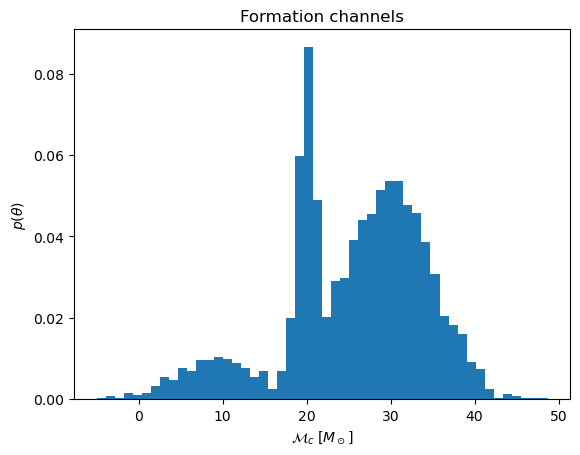

In [2]:
dati = np.load('C:/Users/hp/.spyder-py3/astrostatistics_bicocca_2024/solutions/formationchannels.npy')
plt.hist(dati, bins = 50, density = True)
plt.xlabel(r'$\mathcal{M}_c$ $[M_\odot]$')
plt.ylabel(r'$p(\theta)$')
plt.title('Formation channels')
plt.show()

### 2. AIC and BIC

From the histogram, it is possible to see that there seems to be different formation channels - comparable with separated gaussians. To check whether this is true and how many are they, we can compute the AIC and BIC for Gaussian Mixtures with different number of components.

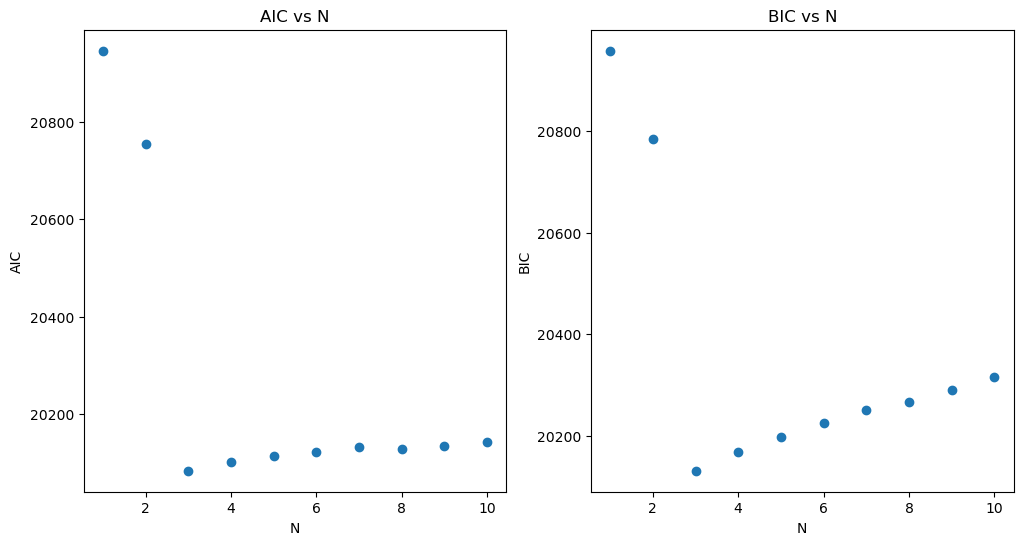

In [3]:
N = [1,2,3,4,5,6,7,8,9,10]
AIC, BIC = [], []
for i in N:
    gm = GaussianMixture(n_components=i, random_state=0).fit(dati)
    #fig = plt.figure()
    #plt.hist(dati, bins = 50, density = True)
    #plt.plot(a, np.exp(gm.score_samples(a[:,np.newaxis])))
    AIC.append(gm.aic(dati))
    BIC.append(gm.bic(dati))
    i = i+1

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(N, AIC)
ax.set_xlabel('N')
ax.set_ylabel('AIC')
ax.set_title('AIC vs N')

ax = fig.add_subplot(122)
ax.scatter(N, BIC)
ax.set_xlabel('N')
ax.set_ylabel('BIC')
ax.set_title('BIC vs N');

### 3. Gaussian Mixture

From this plot, we can see that both the AIC and BIC are minimized by a number of components equal to 3. Therefore, we can fit the data with a Gaussian Mixture with 3 components to observe how it works.

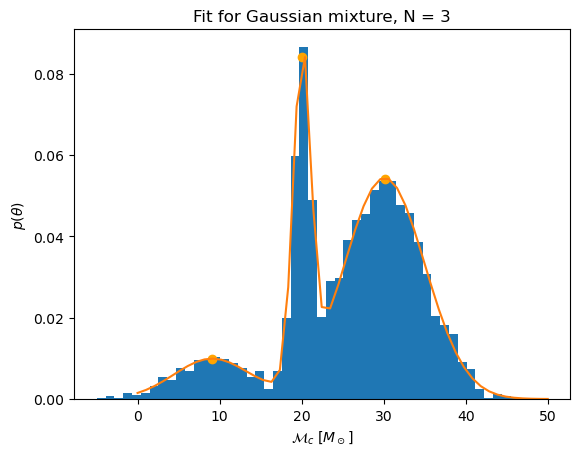

In [4]:
a = np.linspace(0,50)

gm = GaussianMixture(n_components=3, random_state=0).fit(dati)
plt.hist(dati, bins = 50, density = True)
pdf = np.exp(gm.score_samples(a[:,np.newaxis]))
plt.plot(a, pdf)
plt.xlabel(r'$\mathcal{M}_c$ $[M_\odot]$')
plt.ylabel(r'$p(\theta)$')
plt.title('Fit for Gaussian mixture, N = 3')

plt.scatter(gm.means_[0], pdf[np.argmin(np.abs(gm.means_[0]-a))], color = 'orange')
plt.scatter(gm.means_[1], pdf[np.argmin(np.abs(gm.means_[1]-a))], color = 'orange')
plt.scatter(gm.means_[2], pdf[np.argmin(np.abs(gm.means_[2]-a))], color = 'orange')

plt.show()

In [5]:
means = gm.means_
variances = np.sqrt(gm.covariances_)

### 4. Dividing Contributes with Brute Force  

We can star from an assumption: the values contribute to the gaussian to which they are closest with respect to the mean and the variance of given gaussian.

In [6]:
distances = np.array([value-np.array(means) for value in dati] ) 
dist_1 = means[2]+ 1.5*variances[2]
dist_2 = means[1]+ 1.5*variances[1]

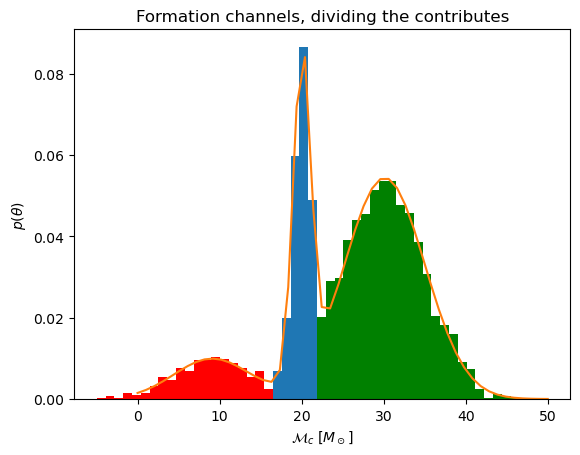

In [7]:
ax = plt.gca()
N, bins, patches = ax.hist(dati, linewidth=1, bins = 50, density = True)
for i, value in enumerate(bins):
    if value < dist_1: 
        patches[i].set_facecolor('red')
    if (value > dist_1) & (value> dist_2):    
        patches[i].set_facecolor('blue')
    if value > dist_2:
        if i == len(patches)-1:
            break
        patches[i].set_facecolor('green')

plt.plot(a, np.exp(gm.score_samples(a[:,np.newaxis])))
plt.xlabel(r'$\mathcal{M}_c$ $[M_\odot]$')
plt.ylabel(r'$p(\theta)$')
plt.title('Formation channels, dividing the contributes')
plt.show()

### 4. Dividing Contributes with Gaussian Mixture

Gaussian Mixture allows to take into consideration the intersections of the different gaussian, which the "brute force" method is not able to. This can be observed by computing the responsabilities.

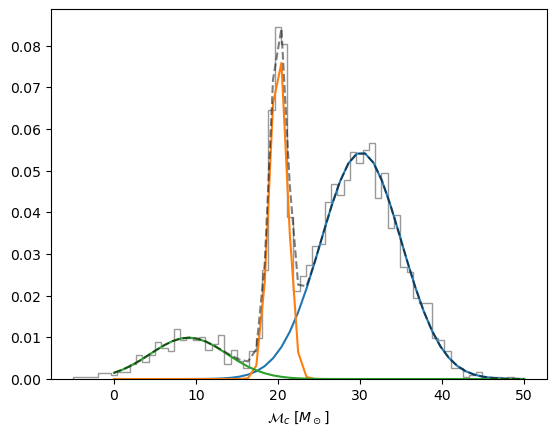

In [8]:
responsibilities = gm.predict_proba(a.reshape(-1, 1))
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(dati, 70, density=True, histtype='step', alpha=0.4,color='black')
plt.plot(a, pdf_individual[:,0], c='C0')
plt.plot(a, pdf_individual[:,1], c='C1')
plt.plot(a, pdf_individual[:,2], c='C2')
plt.plot(a, pdf, '--k', alpha = 0.5)
plt.xlabel(r'$\mathcal{M}_c$ $[M_\odot]$');